# Ensemble Modelling of ML and DL models along with Sentiment Analysis to predict stock price direction

## 1. Introduction
A selection of machine learning classifier models will be used to predict whether the next day Adjusted Close price of Reliance Industry stock will increase or decrease based on sentiment analysis of market news articles from 2011-2023 collected by web scraping from [moneycontrol.com](https://www.moneycontrol.com/company-article/relianceindustries/news/RI). 

Sentiment Analysis is the use of NLP, text analysis and computational linguistics to determine subjective information. Instead of building our own lexicon to do this, we will use VADER (Valence Aware Dictionary and sEntiment Reasoner), a pre-trained sentiment analysis model included in the NLTK package. We will also use TextBlob, a simple API built upon NLTK, for common NLP tasks.

## 2. Import libraries

In [3]:
# Load, explore, process and plot data
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Train Test Split
from sklearn.model_selection import train_test_split,cross_val_score

#Text Preprocessing
import nltk
from datetime import date, timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Machine Larning Modeling
import sklearn
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

#Machine Larning Modeling
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier


# Deep Learning Modeling
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Embedding,SpatialDropout1D, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Performance metrices
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.utils.np_utils import to_categorical


# Deep Learning Modeling
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Embedding,SpatialDropout1D, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Performance metrices
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 3. Import data

Read article sentiment data collected by web scraping from moneycontrol.com into a DataFrame.

In [4]:
# Show DataFrame of article sentiments data

article_sentiments = pd.read_csv('News_Data/RI(2011_2023)_articleBody_Sentiment_Score.csv') 
article_sentiments.head(5)

company              datePublished   
0      RI  2011-01-03T13:19:20+05:30  \
1      RI  2011-01-03T13:19:20+05:30   
2      RI  2011-01-11T15:24:12+05:30   
3      RI  2011-01-11T15:24:12+05:30   
4      RI  2011-01-13T13:37:17+05:30   

                                          author   
0  {'@type': 'Person', 'name': 'webtech_news18'}  \
1  {'@type': 'Person', 'name': 'webtech_news18'}   
2  {'@type': 'Person', 'name': 'webtech_news18'}   
3  {'@type': 'Person', 'name': 'webtech_news18'}   
4    {'@type': 'Person', 'name': 'Rakesh Patil'}   

                                            headline   
0  RIL commissions biz transformation plans for F...  \
1  RIL commissions biz transformation plans for F...   
2  Reliance Industries D6 block capacity falls to...   
3  Reliance Industries D6 block capacity falls to...   
4    RIL Dec qtr PAT seen up 38% at Rs 5535cr: Angel   

                                         description   
0  Reliance Industries (RIL) has commissioned bus...  \
1  Reliance Industries (RIL) has commissioned bus...   
2  Reliance Industries has a current gas output c...   
3  Reliance Industries has a current gas output c...   
4  Angel Broking has come out with its earning es...   

                                                tags   
0  BP, Business, E&P, exploration, Jamnagar, oil,...  \
1  BP, Business, E&P, exploration, Jamnagar, oil,...   
2  Business, D6 block, India's upstream regulator...   
3  Business, D6 block, India's upstream regulator...   
4    Angel Broking, Brokerage Results Estimates, RIL   

                                                 url   
0  https://www.moneycontrol.com//news/business/ri...  \
1  https://www.moneycontrol.com//news/business/ri...   
2  https://www.moneycontrol.com//news/business/re...   
3  https://www.moneycontrol.com//news/business/re...   
4  https://www.moneycontrol.com//news/brokerage-r...   

                                         articleBody    neg    neu    pos   
0  Reliance Industries (RIL) has commissioned bus...  0.000  0.925  0.075  \
1  Reliance Industries (RIL) has commissioned bus...  0.000  0.925  0.075   
2  Reliance Industries has a current gas output c...  0.167  0.797  0.036   
3  Reliance Industries has a current gas output c...  0.167  0.797  0.036   
4  Angel Broking has come out with its earning es...  0.074  0.849  0.077   

   compound  
0    0.6124  
1    0.6124  
2   -0.9382  
3   -0.9382  
4    0.0258

In [5]:
article_sentiments['datePublished'] = pd.to_datetime(article_sentiments['datePublished'])
article_sentiments['datePublished'] = article_sentiments['datePublished'].dt.date

In [6]:
# Create copy of DataFrame

article_sentiments_RI = article_sentiments.copy()

## 4. Clean news data

Prepare data for further processing by appending separator to body text of each article.

In [7]:
# Append ---newarticle--- to split for NLP

article_sentiments_RI['articleBody'] = article_sentiments_RI['articleBody'].astype(str) + '---newarticle---'
RI_articleBody = article_sentiments_RI['articleBody']
pd.set_option("display.max_colwidth", 1)  # to display full text

In [8]:
# Save article_sentiments_azn to txt

with open('News_Data/RI_articleBody_20112023.txt', 'w') as f:
    f.write(
        RI_articleBody.to_string(header = False, index = False)
    )

### Remove spaces in text file

In [9]:
# first get all lines from file
with open('News_Data/RI_articleBody_20112023.txt', 'r') as f:
    lines = f.readlines()

# remove spaces
lines = [line.replace(' ', '') for line in lines]

# finally, write lines in the file
with open('RI_articleBody_20112023.txt', 'w') as f:
    f.writelines(lines)

### Remove end line breaks from text file

In [10]:
# first get all lines from file
a_file = open("News_Data/RI_articleBody_20112023.txt", "r")

# create variable for string without line breaks
string_without_line_breaks = ""

# iterate over strings 
for line in a_file:
  stripped_line = line.rstrip() # rstrip() method removes any trailing characters - space is the default trailing character to remove
  string_without_line_breaks += stripped_line
a_file.close()

In [11]:
# finally, write lines in the file
with open('News_Data/RI_articleBody_20112023.txt', 'w') as f:
    f.writelines(string_without_line_breaks)

In [12]:
# Read article sentiments data into DataFrame 

RI_news_df = pd.read_csv('News_Data/RI(2011_2023)_articleBody_Sentiment_Score.csv')
RI_news_df['datePublished'] = pd.to_datetime(RI_news_df['datePublished'])
RI_news_df['datePublished'] = RI_news_df['datePublished'].dt.date

In [13]:
# Check data types

RI_news_df.dtypes

company          object 
datePublished    object 
author           object 
headline         object 
description      object 
tags             object 
url              object 
articleBody      object 
neg              float64
neu              float64
pos              float64
compound         float64
dtype: object

In [14]:
# Create copy of DataFrame

RI_news_df_new = RI_news_df.copy()

### Drop rows without publish date

In [15]:
# Drop rows with None in publish_date column

RI_news_df_new = RI_news_df_new.replace(to_replace='None', value=np.nan).dropna()
RI_news_df_new.head(1)

company datePublished                                         author   
0  RI      2011-01-03    {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                     headline   
0  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                             description   
0  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                 tags   
0  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                 url   
0  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              articleBody   
0  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

   neg    neu    pos  compound  
0  0.0  0.925  0.075  0.6124

### Drop rows with duplicate titles

In [16]:
# Dropping all duplicate titles keeping only the first instance

RI_news_df_new.drop_duplicates(subset ="headline", 
                     keep = 'first', inplace = True)

RI_news_df_new.head(1)

company datePublished                                         author   
0  RI      2011-01-03    {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                     headline   
0  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                             description   
0  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                 tags   
0  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                 url   
0  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              articleBody   
0  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

   neg    neu    pos  compound  
0  0.0  0.925  0.075  0.6124

### Set datetime index

In [17]:
RI_news_df_new.dtypes

company          object 
datePublished    object 
author           object 
headline         object 
description      object 
tags             object 
url              object 
articleBody      object 
neg              float64
neu              float64
pos              float64
compound         float64
dtype: object

In [18]:

# Set string representation of date to datetime index

RI_news_df_new['Date'] = pd.to_datetime(RI_news_df_new.datePublished)
RI_news_df_new.set_index('Date', inplace=True)
RI_news_df_new.head(1)

company datePublished   
Date                               
2011-01-03  RI      2011-01-03    \

                                                   author   
Date                                                        
2011-01-03  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                              headline   
Date                                                                     
2011-01-03  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                                      description   
Date                                                                                                                                
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                          tags   
Date                                                             
2011-01-03  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                          url   
Date                                                                                                                            
2011-01-03  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       articleBody   
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

            neg    neu    pos  compound  
Date                                     
2011-01-03  0.0  0.925  0.075  0.6124

In [19]:
# Show dateime index of new DataFrame

RI_news_df_new.index

DatetimeIndex(['2011-01-03', '2011-01-11', '2011-01-13', '2011-01-17',
               '2011-01-20', '2011-01-21', '2011-01-21', '2011-01-21',
               '2011-01-24', '2011-01-27',
               ...
               '2023-03-31', '2023-03-31', '2023-04-03', '2023-04-20',
               '2023-04-21', '2023-04-21', '2023-04-21', '2023-04-22',
               '2023-04-24', '2023-05-01'],
              dtype='datetime64[ns]', name='Date', length=2019, freq=None)

In [20]:
# Sort in chronological order

RI_news_df_new = RI_news_df_new.sort_index()
RI_news_df_new.head(1)

company datePublished   
Date                               
2011-01-03  RI      2011-01-03    \

                                                   author   
Date                                                        
2011-01-03  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                              headline   
Date                                                                     
2011-01-03  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                                      description   
Date                                                                                                                                
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                          tags   
Date                                                             
2011-01-03  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                          url   
Date                                                                                                                            
2011-01-03  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       articleBody   
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

            neg    neu    pos  compound  
Date                                     
2011-01-03  0.0  0.925  0.075  0.6124

In [21]:
# Save sorted DataFrame 

RI_news_df_new.to_pickle("News_Data/RI_news_df_new_20112023.pkl")

In [22]:
RI_news_df_new.to_csv("News_Data/RI_news_df_new_20112023.csv", sep=',', encoding='utf-8', header=True)

In [23]:
RI_news_df_new.dtypes

company          object 
datePublished    object 
author           object 
headline         object 
description      object 
tags             object 
url              object 
articleBody      object 
neg              float64
neu              float64
pos              float64
compound         float64
dtype: object

In [24]:
# Create copy of DataFrame 

RI_news_df_combined = RI_news_df_new.copy()

### Combine articles published on same date

Combine all news articles published on same date to get a single score. An alternative method could be to take the mean score of all articles published on the same date.

In [25]:
# Combining all the news published on a single date in a separate column

RI_news_df_combined['news_combined'] = RI_news_df_combined.groupby(['datePublished'])['articleBody'].transform(lambda x: ' '.join(x))

RI_news_df_combined.head(1)

company datePublished   
Date                               
2011-01-03  RI      2011-01-03    \

                                                   author   
Date                                                        
2011-01-03  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                              headline   
Date                                                                     
2011-01-03  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                                      description   
Date                                                                                                                                
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                          tags   
Date                                                             
2011-01-03  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                          url   
Date                                                                                                                            
2011-01-03  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       articleBody   
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

            neg    neu    pos  compound   
Date                                      
2011-01-03  0.0  0.925  0.075  0.6124    \

                                                                                                                                                                                                                                                                                                       

In [26]:
# Dropping duplicate dates keeping only the first instance

RI_news_df_combined.drop_duplicates(subset ="datePublished", 
                     keep = 'first', inplace = True)

In [27]:
# Show DataFrame to check that the number of rows has decreased

RI_news_df_combined.head(1)

company datePublished   
Date                               
2011-01-03  RI      2011-01-03    \

                                                   author   
Date                                                        
2011-01-03  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                              headline   
Date                                                                     
2011-01-03  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                                      description   
Date                                                                                                                                
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                          tags   
Date                                                             
2011-01-03  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                          url   
Date                                                                                                                            
2011-01-03  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       articleBody   
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

            neg    neu    pos  compound   
Date                                      
2011-01-03  0.0  0.925  0.075  0.6124    \

                                                                                                                                                                                                                                                                                                       

In [28]:
# Save combined DataFrame without duplicates

RI_news_df_combined.to_csv("News_Data/RI_news_df_combined_20112023.csv", sep=',', encoding='utf-8', header=True)

In [29]:
RI_news_df_combined = pd.read_csv("News_Data/RI_news_df_combined_20112023.csv")
RI_news_df_combined.head(1)

Date company datePublished   
0  2011-01-03  RI      2011-01-03    \

                                          author   
0  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                     headline   
0  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                             description   
0  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                 tags   
0  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                 url   
0  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              articleBody   
0  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

   neg    neu    pos  compound   
0  0.0  0.925  0.075  0.6124    \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            news_combined  
0  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;

### Set datetime index

In [30]:
# Set string representation of date to datetime index

RI_news_df_combined['Date'] = pd.to_datetime(RI_news_df_combined.datePublished)
RI_news_df_combined.set_index('Date', inplace=True)
RI_news_df_combined.head(1)

company datePublished   
Date                               
2011-01-03  RI      2011-01-03    \

                                                   author   
Date                                                        
2011-01-03  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                              headline   
Date                                                                     
2011-01-03  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                                      description   
Date                                                                                                                                
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                          tags   
Date                                                             
2011-01-03  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                          url   
Date                                                                                                                            
2011-01-03  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       articleBody   
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

            neg    neu    pos  compound   
Date                                      
2011-01-03  0.0  0.925  0.075  0.6124    \

                                                                                                                                                                                                                                                                                                       

## 5. Import historical stock data 

Import stock data for same period as news data from Yahoo! Finance using yfinance API.

In [31]:
RI_stock_df = yf.download("RELIANCE.NS", start="2011-04-03", end="2023-03-31")
RI_stock_df

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close   
Date                                                                          
2011-04-04  515.117188   522.447693   509.668854   520.392212   474.875366   \
2011-04-05  521.308533   524.528015   515.117188   518.906311   473.519440    
2011-04-06  517.593750   522.175293   515.117188   517.519409   472.253906    
2011-04-07  517.618469   518.856750   512.690186   516.058289   470.920593    
2011-04-08  516.107788   520.516052   505.533051   507.142792   462.784882    
...                ...          ...          ...          ...          ...    
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume  
Date                 
2011-04-04  6051061  
2011-04-05  4964260  
2011-04-06  4191928  
2011-04-07  4690528  
2011-04-08  5536031  
...             ...  
2023-03-23  7499082  
2023-03-24  5711497  
2023-03-27  6486068  
2023-03-28  5804018  
2023-03-29  8678073  

[2957 rows x 6 columns]

### Visualise Adjusted Close price and Volume 

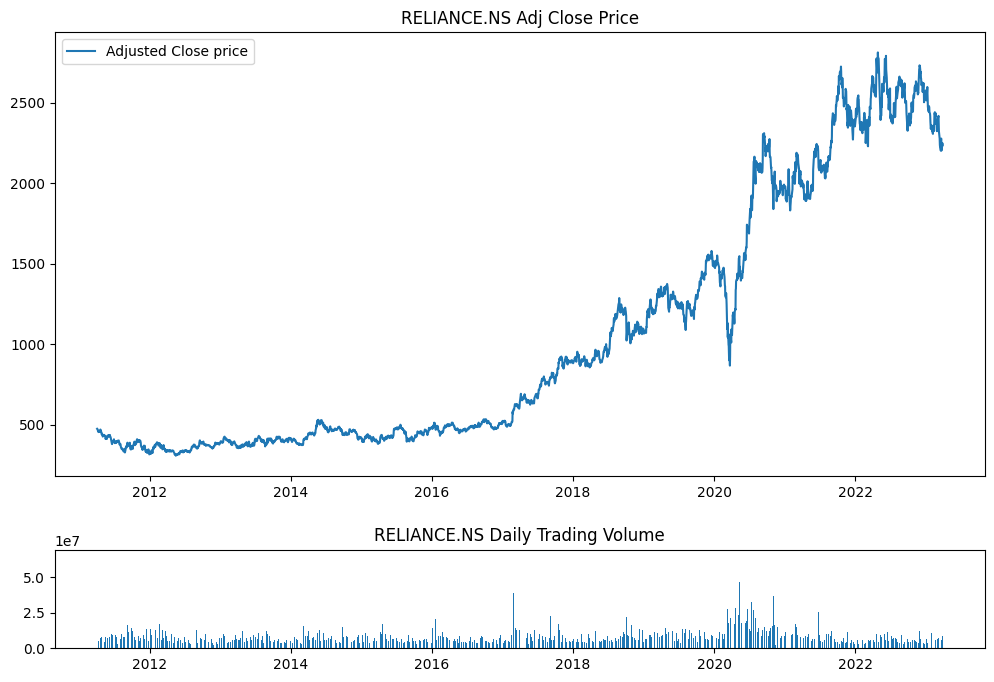

In [32]:
# Plot Adjusted Close price and Volume

top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4) 
top.plot(RI_stock_df.index, RI_stock_df['Adj Close'], label = 'Adjusted Close price') 
plt.title('RELIANCE.NS Adj Close Price') 
plt.legend(loc=2) 
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4) 
bottom.bar(RI_stock_df.index, RI_stock_df["Volume"]) 
plt.title('RELIANCE.NS Daily Trading Volume') 
plt.gcf().set_size_inches(12,8) 
plt.subplots_adjust(hspace=0.75)

## 6. Merge Stock and Sentiment Dataframes on Date

In [33]:
RI_news_df_combined.head(1)

company datePublished   
Date                               
2011-01-03  RI      2011-01-03    \

                                                   author   
Date                                                        
2011-01-03  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                              headline   
Date                                                                     
2011-01-03  RIL commissions biz transformation plans for FY12: sources  \

                                                                                                                      description   
Date                                                                                                                                
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources.  \

                                                          tags   
Date                                                             
2011-01-03  BP, Business, E&P, exploration, Jamnagar, oil, RIL  \

                                                                                                                          url   
Date                                                                                                                            
2011-01-03  https://www.moneycontrol.com//news/business/ril-commissions-biz-transformation-plans-for-fy12-sources_509910.html  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       articleBody   
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2011-01-03  Reliance Industries (RIL) has commissioned business transformation plans for FY12, reports CNBC-TV18 quoting sources. It is learnt that RIL has mandated ATKearney and Booz &amp;amp;amp; Co for business transformation to make it process driven on the lines of Exxon and Shell. Sources add that RIL is likely to finalise a USD 5 billion plan at Jamnagar in 2011 which includes new cracker and downstream expansion. The decision on building LNG terminal may be taken in 2011. However, it may not be in Jamnagar.  Further RIL has revived talks with BP to sell stake in exploration and production (E&amp;amp;amp;P) assets.  &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp; &amp;amp;nbsp;  \

            neg    neu    pos  compound   
Date                                      
2011-01-03  0.0  0.925  0.075  0.6124    \

                                                                                                                                                                                                                                                                                                       

In [34]:
# Merge data sets on date
merge = RI_stock_df.merge(RI_news_df_combined, how='inner', left_index=True, right_index=True)
merge.head(1)

Open        High         Low       Close   Adj Close   
Date                                                                     
2011-04-04  515.117188  522.447693  509.668854  520.392212  474.875366  \

             Volume company datePublished   
Date                                        
2011-04-04  6051061  RI      2011-04-04    \

                                                   author   
Date                                                        
2011-04-04  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                             headline   
Date                                                                    
2011-04-04  Sell Reliance Inds; tgt of Rs 980/960: Aditya Birla Money  \

                                                                                                                                                                    description   
Date                                                                                                                                                                              
2011-04-04  Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report.  \

                                                                                tags   
Date                                                                                   
2011-04-04  Aditya Birla Money, recommendation, Recommendations, Reliance Industries  \

                                                                                                                          url   
Date                                                                                                                            
2011-04-04  https://www.moneycontrol.com//news/recommendations/sell-reliance-inds-tgtrs-980960-aditya-birla-money_533800.html  \

                                                                                                                                                                     articleBody   
Date                                                                                                                                                                               
2011-04-04  Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report.   \

            neg    neu    pos  compound   
Date                                      
2011-04-04  0.0  0.839  0.161  0.3612    \

                                                                                                                                                                   news_combined  
Date                                                                                                                                                                              
2011-04-04  Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report.

In [35]:
# Save DataFrame with subjectivity and polarity scores
merge.to_csv("News_Data/RI__merge_cleaned_subj_pol_20112023.csv", sep=',', encoding='utf-8', header=True)

In [36]:
# Show first row in combined news column

merge['news_combined'].iloc[0]

'Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report. '

In [37]:
# Iterate over rows in combined news column

for index, row in merge.iterrows(): 
    print (row["news_combined"])

Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report. 
KRChoksey has come out with its earning estimates on diversified sector for the quarter ended March 2011. According to the research firm, Reliance Industries March quarter sales are expected to go up by 4% at Rs 61,403 crore, year-on-year, (YoY) basis. The company's net profit is expected to go up by 23% at Rs 4,912 crore on YoY basis.
Remain invested in Reliance Industries, says Sanjay Dutt, Director, Quantum Securities. Dutt told CNBC-TV18, &amp;quot;I am bullish on Reliance but there are DVS designs. So just remain invested in this stock that has also got linked a lot to policy action, which is out there in the public domain, I don
Petroleum Ministry has sought security clearance from Home Ministry for allowing UK's BP Plc to buy 30% stake in most of the Reliance Industries' oil and gas blocks, including the giant KG-D6 

### Clean data in combined news column

Strip newline escape sequence (\n), unwanted punctuation and backslashes. 

In [38]:
# Create empty list to append cleaned data from combined news column

clean_news = []

for i in range(0, len(merge["news_combined"])): 
    clean_news.append(re.sub("\n", ' ', merge["news_combined"][i]))  # replace n\ with ' '
    clean_news[i] = re.sub(r'[^\w\d\s\']+', '', clean_news[i]) # remove unwanted punctuation and \'

In [39]:
# Show first row in cleaned combined news column

clean_news[0]

'Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980960 in its April 4 2011 research report '

In [40]:
# Add cleaned news column to merged data set

merge['news_cleaned'] = clean_news


merge['news_cleaned'][0]

'Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980960 in its April 4 2011 research report '

In [41]:
# Show head of merged DataFrame

merge.head(1)

Open        High         Low       Close   Adj Close   
Date                                                                     
2011-04-04  515.117188  522.447693  509.668854  520.392212  474.875366  \

             Volume company datePublished   
Date                                        
2011-04-04  6051061  RI      2011-04-04    \

                                                   author   
Date                                                        
2011-04-04  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                             headline   
Date                                                                    
2011-04-04  Sell Reliance Inds; tgt of Rs 980/960: Aditya Birla Money  \

                                                                                                                                                                    description   
Date                                                                                                                                                                              
2011-04-04  Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report.  \

                                                                                tags   
Date                                                                                   
2011-04-04  Aditya Birla Money, recommendation, Recommendations, Reliance Industries  \

                                                                                                                          url   
Date                                                                                                                            
2011-04-04  https://www.moneycontrol.com//news/recommendations/sell-reliance-inds-tgtrs-980960-aditya-birla-money_533800.html  \

                                                                                                                                                                     articleBody   
Date                                                                                                                                                                               
2011-04-04  Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report.   \

            neg    neu    pos  compound   
Date                                      
2011-04-04  0.0  0.839  0.161  0.3612    \

                                                                                                                                                                   news_combined   
Date                                                                                                                                                                               
2011-04-04  Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report.   \

                                                                                                                                                                 news_cleaned  
Date                                                                                                                                                                           
2011-04-04  Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980960 in its April 4 2011 research report

In [42]:
# Save merged DataFrame

merge.to_csv('News_Data/RI__merge_cleaned_20112023.csv', sep=',', encoding='utf-8', header=True)

## 7. Sentiment Analysis

TextBlob will be used to get subjectivity and polarity scores for the cleaned and merged news data. Polarity is a float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgement whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1] where 0 is objective and 1 is subjective.

In [43]:
# Create function to get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create function to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [44]:
# Create new columns
merge['subjectivity'] = merge['news_cleaned'].apply(getSubjectivity)
merge['polarity'] = merge['news_cleaned'].apply(getPolarity)

In [45]:
# Show new columns
merge.head(1)

Open        High         Low       Close   Adj Close   
Date                                                                     
2011-04-04  515.117188  522.447693  509.668854  520.392212  474.875366  \

             Volume company datePublished   
Date                                        
2011-04-04  6051061  RI      2011-04-04    \

                                                   author   
Date                                                        
2011-04-04  {'@type': 'Person', 'name': 'webtech_news18'}  \

                                                             headline  ...   
Date                                                                   ...   
2011-04-04  Sell Reliance Inds; tgt of Rs 980/960: Aditya Birla Money  ...  \

                                                                                                                          url   
Date                                                                                                                            
2011-04-04  https://www.moneycontrol.com//news/recommendations/sell-reliance-inds-tgtrs-980960-aditya-birla-money_533800.html  \

                                                                                                                                                                     articleBody   
Date                                                                                                                                                                               
2011-04-04  Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report.   \

            neg    neu    pos  compound   
Date                                      
2011-04-04  0.0  0.839  0.161  0.3612    \

                                                                                                                                                                   news_combined   
Date                                                                                                                                                                               
2011-04-04  Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980/960 in its April 4, 2011 research report.   \

                                                                                                                                                                 news_cleaned   
Date                                                                                                                                                                            
2011-04-04  Aditya Birla Money is bearish on Reliance Industries and has recommended sell rating on the stock with a target of Rs 980960 in its April 4 2011 research report   \

           subjectivity polarity  
Date                              
2011-04-04  0.0          0.0      

[1 rows x 22 columns]

In [46]:
# Show shape of DataFrame
merge.shape

(1002, 22)

In [47]:
# Save DataFrame with subjectivity and polarity scores
merge.to_csv("News_Data/RI__merge_cleaned_subj_pol_20112023.csv", sep=',', encoding='utf-8', header=True)

## 9. Feature engineering

We will calculate whether the next day Adjusted Close price increased/held or decreased and label these as 1 and 0 respectively to build and train machine learning classifier models to predict price direction based on sentiment.

In [48]:
# Create copy of stock data

RI_stock_df_label = RI_stock_df.copy()
RI_stock_df_label

Open         High          Low        Close    Adj Close   
Date                                                                          
2011-04-04  515.117188   522.447693   509.668854   520.392212   474.875366   \
2011-04-05  521.308533   524.528015   515.117188   518.906311   473.519440    
2011-04-06  517.593750   522.175293   515.117188   517.519409   472.253906    
2011-04-07  517.618469   518.856750   512.690186   516.058289   470.920593    
2011-04-08  516.107788   520.516052   505.533051   507.142792   462.784882    
...                ...          ...          ...          ...          ...    
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume  
Date                 
2011-04-04  6051061  
2011-04-05  4964260  
2011-04-06  4191928  
2011-04-07  4690528  
2011-04-08  5536031  
...             ...  
2023-03-23  7499082  
2023-03-24  5711497  
2023-03-27  6486068  
2023-03-28  5804018  
2023-03-29  8678073  

[2957 rows x 6 columns]

In [49]:
# "1" when RELIANCE Adj Close value rose or stayed as the same;
# "0" when RELIANCE Adj Close value decreased.

RI_stock_df_label['Adj Close Next'] = RI_stock_df_label['Adj Close'].shift(-1)
RI_stock_df_label['Label'] = RI_stock_df_label.apply(lambda x: 1 if (x['Adj Close Next']>= x['Adj Close']) else 0, axis =1)

RI_stock_df_label[['Adj Close', 'Adj Close Next', 'Label']].head(5)

Adj Close  Adj Close Next  Label
Date                                         
2011-04-04  474.875366  473.519440      0    
2011-04-05  473.519440  472.253906      0    
2011-04-06  472.253906  470.920593      0    
2011-04-07  470.920593  462.784882      0    
2011-04-08  462.784882  454.378021      0

In [50]:
# Save DataFrame

RI_stock_df_label.to_pickle("News_Data/RI_stock_df_labels_20112023.pkl")

In [51]:
RI_stock_df_label.to_csv("News_Data/RI_stock_df_label_20112023.csv", sep=',', encoding='utf-8', header=True)

In [52]:
# Show Adj Close Next and Label with Date

RI_stock_df_label_adj_nxt = RI_stock_df_label[['Adj Close Next', 'Label']]
RI_stock_df_label_adj_nxt

Adj Close Next  Label
Date                             
2011-04-04  473.519440      0    
2011-04-05  472.253906      0    
2011-04-06  470.920593      0    
2011-04-07  462.784882      0    
2011-04-08  454.378021      0    
...                ...     ..    
2023-03-23  2203.300049     0    
2023-03-24  2237.550049     1    
2023-03-27  2248.000000     1    
2023-03-28  2234.699951     0    
2023-03-29 NaN              0    

[2957 rows x 2 columns]

In [53]:
# Drop NaN row

RI_stock_df_label_adj_nxt = RI_stock_df_label_adj_nxt.dropna()
RI_stock_df_label_adj_nxt

Adj Close Next  Label
Date                             
2011-04-04  473.519440      0    
2011-04-05  472.253906      0    
2011-04-06  470.920593      0    
2011-04-07  462.784882      0    
2011-04-08  454.378021      0    
...                ...     ..    
2023-03-22  2247.800049     0    
2023-03-23  2203.300049     0    
2023-03-24  2237.550049     1    
2023-03-27  2248.000000     1    
2023-03-28  2234.699951     0    

[2956 rows x 2 columns]

In [54]:
# Merge DataFrames on date
merge2 = RI_stock_df.merge(RI_stock_df_label_adj_nxt, how='inner', left_index=True, right_index=True)

In [55]:
# Drop NaN row and show merged DataFrame
merge2 = merge2.dropna()
merge2

Open         High          Low        Close    Adj Close   
Date                                                                          
2011-04-04  515.117188   522.447693   509.668854   520.392212   474.875366   \
2011-04-05  521.308533   524.528015   515.117188   518.906311   473.519440    
2011-04-06  517.593750   522.175293   515.117188   517.519409   472.253906    
2011-04-07  517.618469   518.856750   512.690186   516.058289   470.920593    
2011-04-08  516.107788   520.516052   505.533051   507.142792   462.784882    
...                ...          ...          ...          ...          ...    
2023-03-22  2285.000000  2291.449951  2270.000000  2276.600098  2276.600098   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   

             Volume  Adj Close Next  Label  
Date                                        
2011-04-04  6051061  473.519440      0      
2011-04-05  4964260  472.253906      0      
2011-04-06  4191928  470.920593      0      
2011-04-07  4690528  462.784882      0      
2011-04-08  5536031  454.378021      0      
...             ...         ...     ..      
2023-03-22  5039622  2247.800049     0      
2023-03-23  7499082  2203.300049     0      
2023-03-24  5711497  2237.550049     1      
2023-03-27  6486068  2248.000000     1      
2023-03-28  5804018  2234.699951     0      

[2956 rows x 8 columns]

In [56]:
# Save DataFrame
merge2.to_csv("News_Data/RI_prices_labels_20112023.csv", sep=',', encoding='utf-8', header=True)

In [57]:
merge2.to_pickle("News_Data/RI_prices_labels_20112023.pkl")

In [58]:
# Merge next day Adjusted Close price and Label with combined stock data and sentiment DataFrame

merge3 = RI_stock_df_label_adj_nxt.merge(merge, how='inner', left_index=True, right_index=True)
merge3

Adj Close Next  Label         Open         High          Low   
Date                                                                       
2011-04-04  473.519440      0      515.117188   522.447693   509.668854   \
2011-04-05  472.253906      0      521.308533   524.528015   515.117188    
2011-04-07  462.784882      0      517.618469   518.856750   512.690186    
2011-04-13  461.451538      0      496.221313   507.192322   493.620972    
2011-04-15  456.118134      0      504.542450   507.613342   497.781525    
...                ...     ..             ...          ...          ...    
2023-02-08  2356.050049     1      2313.000000  2359.899902  2307.000000   
2023-02-14  2431.949951     1      2329.949951  2381.899902  2323.649902   
2023-02-21  2378.899902     0      2424.000000  2446.800049  2412.350098   
2023-03-16  2223.100098     0      2243.000000  2254.000000  2202.199951   
2023-03-20  2269.699951     1      2215.000000  2220.000000  2180.000000   

                  Close    Adj Close   Volume company datePublished  ...   
Date                                                                 ...   
2011-04-04  520.392212   474.875366   6051061  RI      2011-04-04    ...  \
2011-04-05  518.906311   473.519440   4964260  RI      2011-04-05    ...   
2011-04-07  516.058289   470.920593   4690528  RI      2011-04-07    ...   
2011-04-13  506.102661   461.835693   8822291  RI      2011-04-13    ...   
2011-04-15  505.681641   461.451538   6541425  RI      2011-04-15    ...   
...                ...          ...       ...  ..             ...    ...   
2023-02-08  2351.949951  2351.949951  9765490  RI      2023-02-08    ...   
2023-02-14  2378.100098  2378.100098  6609564  RI      2023-02-14    ...   
2023-02-21  2434.100098  2434.100098  6143298  RI      2023-02-21    ...   
2023-03-16  2225.899902  2225.899902  8474595  RI      2023-03-16    ...   
2023-03-20  2201.250000  2201.250000  9010595  RI      2023-03-20    ...   

                                                                                                                                                                                        url   
Date                                                                                                                                                                                          
2011-04-04  https://www.moneycontrol.com//news/recommendations/sell-reliance-inds-tgtrs-980960-aditya-birla-money_533800.html                                                                \
2011-04-05  https://www.moneycontrol.com//news/brokerage-results-estimates/ril-march-qtr-pat-seen23-at-rs-4912-cr-krchoksey_534090.html                                                       
2011-04-07  https://www.moneycontrol.com//news/stocks-views/remain-investedreliance-industries-sanjay-dutt_534692.html                                                                        
2011-04-13  https://www.moneycontrol.com//news/business/oil-min-seeks-home-mins-nod-for-rel-bp-deal-_535962.html                                                                              
2011-04-15  https://www.moneycontrol.com//news/business/unitech-offered-to-sell-telecom-arm-to-ril-radia-to-cbi_536188.html                                                                   
...                                                                                                          ...                                                                              
2023-02-08  https://www.moneycontrol.com//news/business/reliance-bpcl-among-buyers-using-uae-currency-for-russian-oil_16856841.html                                                           
2023-02-14  https://www.moneycontrol.com//news/buzzing-stocks/to-marketlovev-day-ril-powers-surgeniftysensex_16880121.html                                                                    
2023-02-21  https://www.moneycontrol.com//news/buzzing-stocks/ril-antique-systematic-institutional-equities-place-stock39buy

In [59]:
# Save merged DataFrame

merge3.to_csv("News_Data/RI_prices_labels_news_20112023.csv", sep=',', encoding='utf-8', header=True)

In [60]:
merge3.to_pickle("News_Data/RI_prices_labels_news_20112023.pkl")

In [61]:
merge3 = pd.read_pickle("News_Data/RI_prices_labels_news_20112023.pkl")

In [62]:
# Collapse data set to keep relevant stock price and sentiment score columns only

keep_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'subjectivity', 'polarity', 'compound', 'neg',	'neu',	'pos', 'Label']
df =  merge3[keep_columns]
df

Open         High          Low        Close    Adj Close   
Date                                                                          
2011-04-04  515.117188   522.447693   509.668854   520.392212   474.875366   \
2011-04-05  521.308533   524.528015   515.117188   518.906311   473.519440    
2011-04-07  517.618469   518.856750   512.690186   516.058289   470.920593    
2011-04-13  496.221313   507.192322   493.620972   506.102661   461.835693    
2011-04-15  504.542450   507.613342   497.781525   505.681641   461.451538    
...                ...          ...          ...          ...          ...    
2023-02-08  2313.000000  2359.899902  2307.000000  2351.949951  2351.949951   
2023-02-14  2329.949951  2381.899902  2323.649902  2378.100098  2378.100098   
2023-02-21  2424.000000  2446.800049  2412.350098  2434.100098  2434.100098   
2023-03-16  2243.000000  2254.000000  2202.199951  2225.899902  2225.899902   
2023-03-20  2215.000000  2220.000000  2180.000000  2201.250000  2201.250000   

             Volume  subjectivity  polarity  compound    neg    neu    pos   
Date                                                                         
2011-04-04  6051061  0.000000      0.000000  0.3612    0.000  0.839  0.161  \
2011-04-05  4964260  0.300000     -0.100000  0.4404    0.000  0.912  0.088   
2011-04-07  4690528  0.083333      0.050000  0.0000    0.000  1.000  0.000   
2011-04-13  8822291  0.371111     -0.021111 -0.4019    0.113  0.804  0.083   
2011-04-15  6541425  0.342857      0.083929  0.7184    0.000  0.937  0.063   
...             ...       ...           ...     ...      ...    ...    ...   
2023-02-08  9765490  0.433974     -0.014103 -0.9460    0.106  0.848  0.045   
2023-02-14  6609564  0.419753      0.075786  0.9732    0.012  0.828  0.160   
2023-02-21  6143298  0.495874      0.028185  0.9861    0.054  0.815  0.130   
2023-03-16  8474595  0.398215      0.065542  0.9902    0.061  0.771  0.168   
2023-03-20  9010595  0.383233      0.038555  0.8979    0.042  0.857  0.101   

            Label  
Date               
2011-04-04  0      
2011-04-05  0      
2011-04-07  0      
2011-04-13  0      
2011-04-15  0      
...        ..      
2023-02-08  1      
2023-02-14  1      
2023-02-21  0      
2023-03-16  0      
2023-03-20  1      

[1002 rows x 13 columns]

## 10. Modelling

Split the data in feature matrix (X) and target vector (y).

In [136]:
# Create feature data set
X = df
X = np.array(X.drop(['Label'], axis=1))

# Create target data set
y = np.array(df['Label'])

We will split the data into train and test sets to verify predictions. Time series data cannot be split randomly as this would introduce look-ahead bias so the first 80% will be the training set and the last 20% the test set.

In [137]:
# Split data into 80% training and 20% testing data sets

split = int(0.8*len(df))

In [138]:
X_train = X[0:split]
y_train = y[0:split]

X_test = X[split:]
y_test = y[split:]

In [139]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(800, 12)
(800,)
(200, 12)
(200,)


In [67]:
# Function for confusion matrix

def plot_confusion_matrix(y_true, y_pred, labels=["Decrease", "Increase"], 
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

In [68]:
# Create and train the model
model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [69]:
# Show model's predictions
predictions = model.predict(X_test)
predictions

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0], dtype=int64)

In [70]:
# Show actual values
y_test

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1], dtype=int64)

In [71]:
# Show model metrics 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.59      0.43      0.50       111
           1       0.47      0.63      0.54        90

    accuracy                           0.52       201
   macro avg       0.53      0.53      0.52       201
weighted avg       0.54      0.52      0.52       201



### Feature scaling

We will standardise the data using scikit-learn's preprocessing.scale() algorithm so that it is all on one scale.

In [72]:
# Standardise X's
X_train = scale(X_train)
X_test = scale(X_test)

### Create function for confusion matrix to visualise performance

In [73]:
def plot_matrix(y_test, y_pred, color="Greens"):
    labels = np.unique(y_pred)
    cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)
    sns.heatmap(cm_df, annot=True, fmt='g', cmap=color)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()


-------------- Decision Tree ---------------



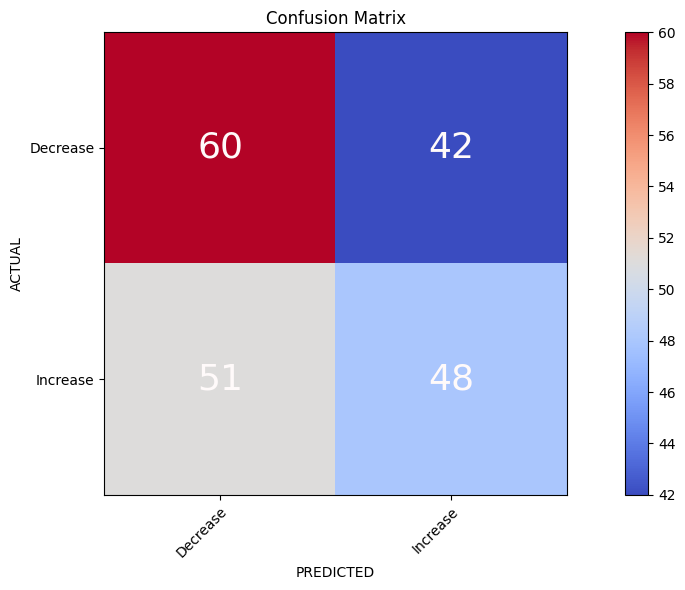

              precision    recall  f1-score   support

    Decrease       0.54      0.59      0.56       102
    Increase       0.53      0.48      0.51        99

    accuracy                           0.54       201
   macro avg       0.54      0.54      0.54       201
weighted avg       0.54      0.54      0.54       201


-------------- Bernoulli NB ---------------



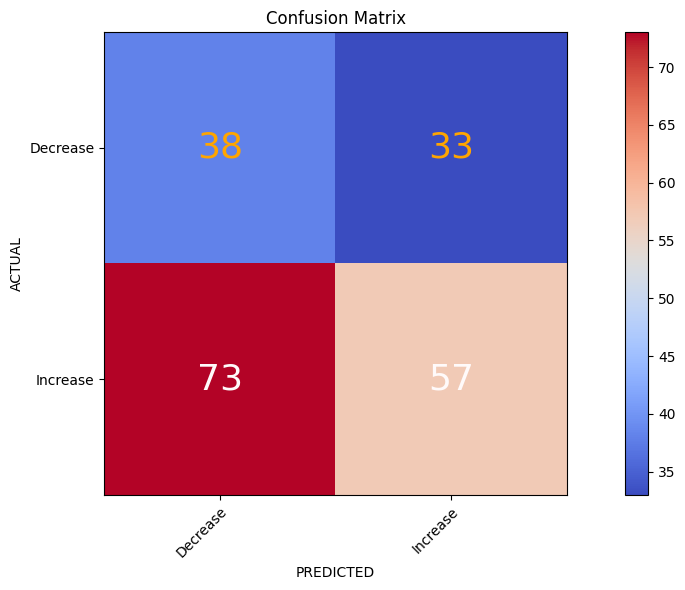

              precision    recall  f1-score   support

    Decrease       0.34      0.54      0.42        71
    Increase       0.63      0.44      0.52       130

    accuracy                           0.47       201
   macro avg       0.49      0.49      0.47       201
weighted avg       0.53      0.47      0.48       201


-------------- Logistic Regression ---------------



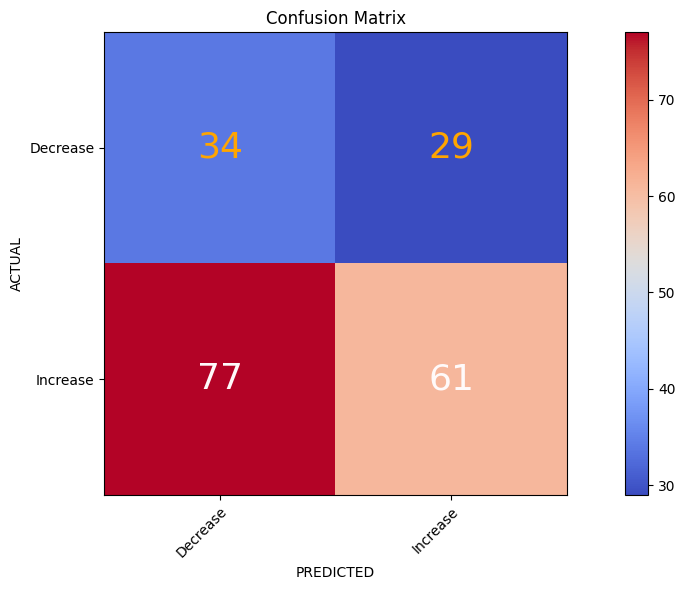

              precision    recall  f1-score   support

    Decrease       0.31      0.54      0.39        63
    Increase       0.68      0.44      0.54       138

    accuracy                           0.47       201
   macro avg       0.49      0.49      0.46       201
weighted avg       0.56      0.47      0.49       201


-------------- LinearDiscriminantAnalysis ---------------



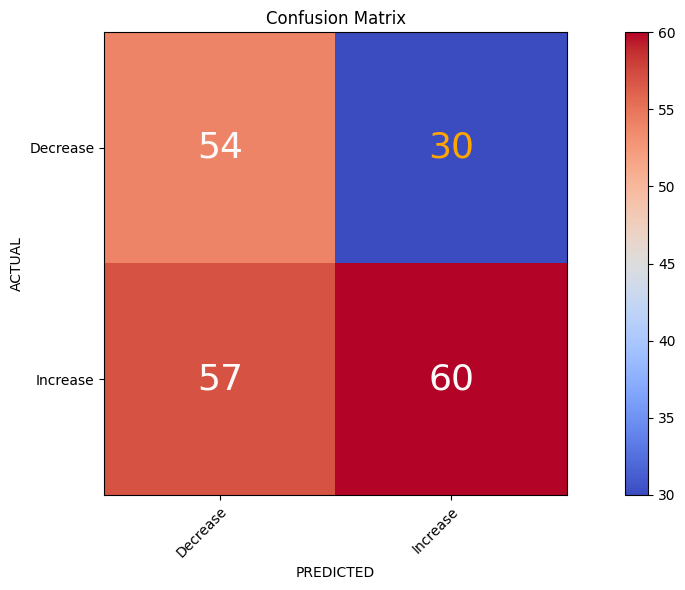

              precision    recall  f1-score   support

    Decrease       0.49      0.64      0.55        84
    Increase       0.67      0.51      0.58       117

    accuracy                           0.57       201
   macro avg       0.58      0.58      0.57       201
weighted avg       0.59      0.57      0.57       201


-------------- SVM Classification ---------------



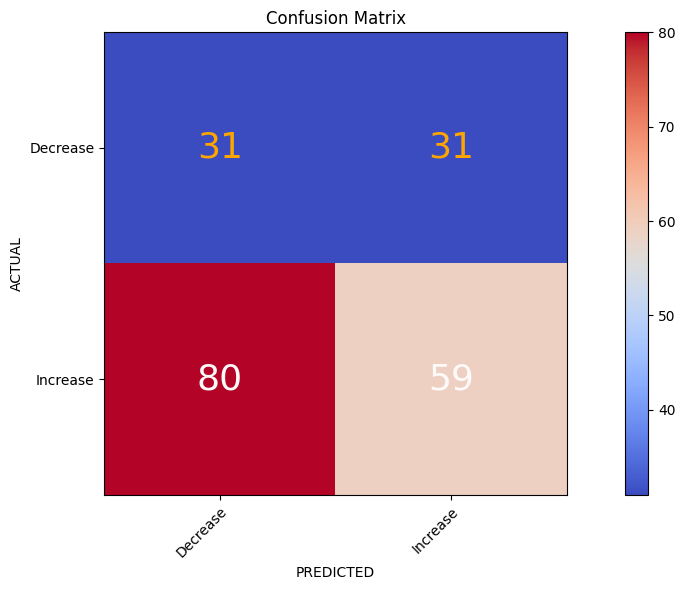

              precision    recall  f1-score   support

    Decrease       0.28      0.50      0.36        62
    Increase       0.66      0.42      0.52       139

    accuracy                           0.45       201
   macro avg       0.47      0.46      0.44       201
weighted avg       0.54      0.45      0.47       201


-------------- SGDClassifier ---------------



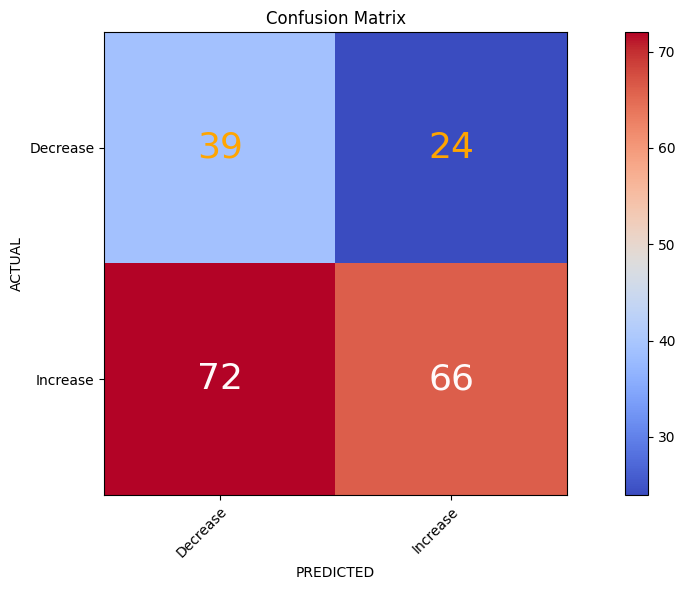

              precision    recall  f1-score   support

    Decrease       0.35      0.62      0.45        63
    Increase       0.73      0.48      0.58       138

    accuracy                           0.52       201
   macro avg       0.54      0.55      0.51       201
weighted avg       0.61      0.52      0.54       201


-------------- KNeighborsClassifier ---------------



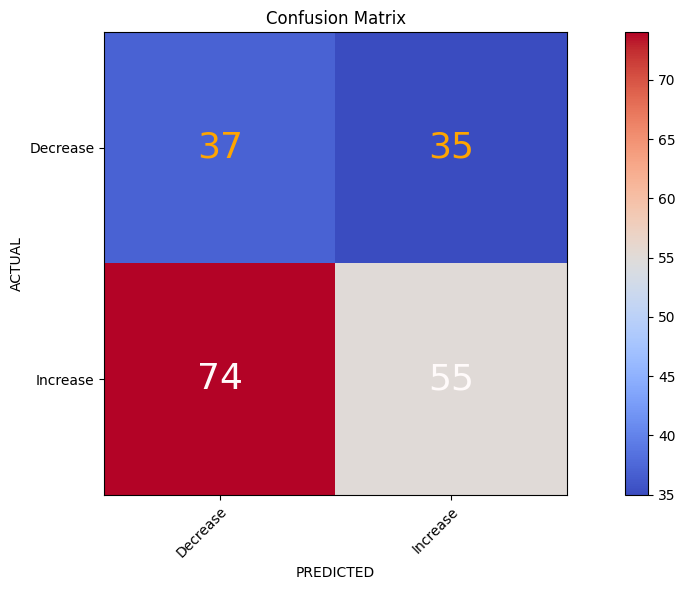

              precision    recall  f1-score   support

    Decrease       0.33      0.51      0.40        72
    Increase       0.61      0.43      0.50       129

    accuracy                           0.46       201
   macro avg       0.47      0.47      0.45       201
weighted avg       0.51      0.46      0.47       201


-------------- GaussianProcessClassifier ---------------



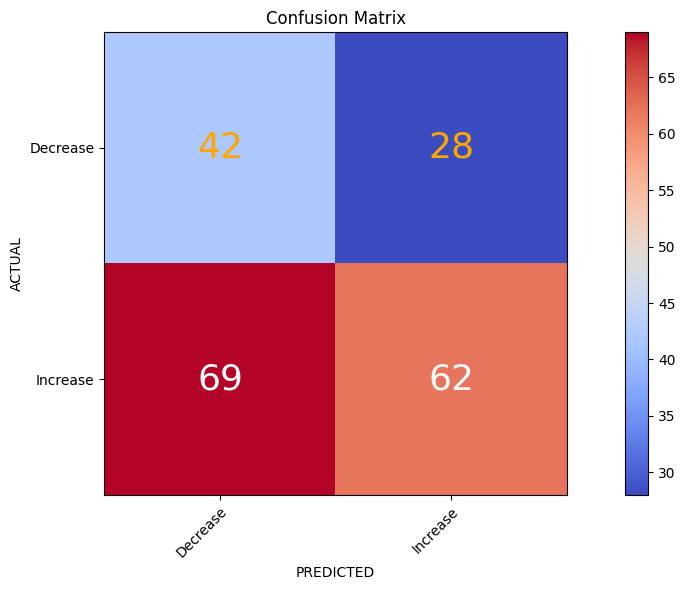

              precision    recall  f1-score   support

    Decrease       0.38      0.60      0.46        70
    Increase       0.69      0.47      0.56       131

    accuracy                           0.52       201
   macro avg       0.53      0.54      0.51       201
weighted avg       0.58      0.52      0.53       201


-------------- RandomForestClassifier ---------------



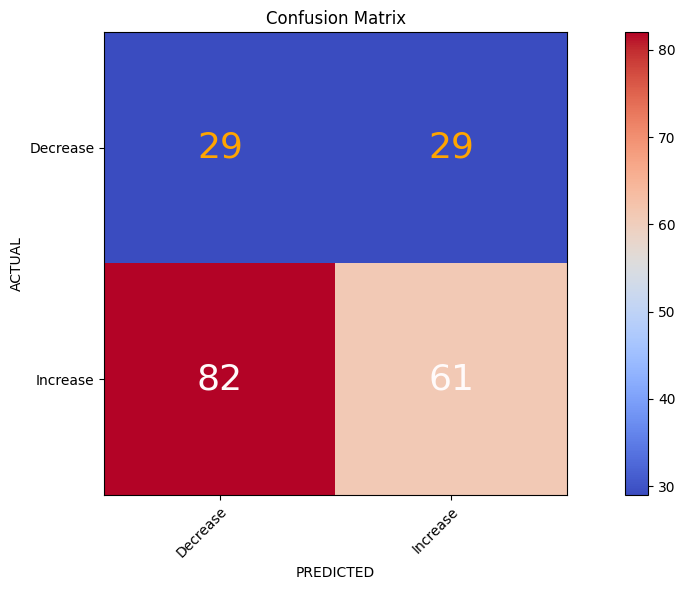

              precision    recall  f1-score   support

    Decrease       0.26      0.50      0.34        58
    Increase       0.68      0.43      0.52       143

    accuracy                           0.45       201
   macro avg       0.47      0.46      0.43       201
weighted avg       0.56      0.45      0.47       201



In [74]:
# test models
models = {  
            'Decision Tree': DecisionTreeClassifier(criterion='entropy',max_depth=None),
            'Bernoulli NB': BernoulliNB(),
            'Logistic Regression' : LogisticRegression(),
            'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
            'SVM Classification': SVC(),
            'SGDClassifier': SGDClassifier(loss="hinge", penalty="l2", max_iter=100),
            'KNeighborsClassifier':KNeighborsClassifier(n_neighbors=9),
            'GaussianProcessClassifier': GaussianProcessClassifier(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=100)
            }

for model_name in models.keys():

    model = models[model_name]
    print('\n'+'--------------',model_name,'---------------'+'\n')
    model.fit(X_train,y_train)
    # Plot confusion matrix
    plot_confusion_matrix(model.predict(X_test),y_test, title="Confusion Matrix")
    #plot_matrix(model.predict(X_test),y_test)
    np.set_printoptions(precision=1)
    plt.show()
    # Final Classification Report
    print(classification_report(model.predict(X_test),y_test, target_names=['Decrease', 'Increase']))

### Conclusion
The precision score is the 'exactness', or ability of the model to return only relevant instances. When a model makes a prediction, how often it is correct?

It appears that the model which correctly predicted the increase in price most often was the Bernoulli NB at 76%, and the Decision Tree Classifier was best at predicting the decrease in price 54% of the time.

None of the scores were particularly outstanding and further improvements might include updating the lexicon with words and sentiments from other more specialised sources such as the Loughran-McDonald Financial Sentiment Word Lists. This would likely result in more accurate sentiment analysis as it was specifically built for financial text whereas VADER is more attuned to sentiments expressed in social media.

# Ensemble Machine Learning Models

In [140]:
df

Open         High          Low        Close    Adj Close   
Date                                                                          
2019-01-24  1213.497314  1241.432495  1208.643311  1235.736450  1216.744385  \
2019-10-17  1362.088745  1385.863403  1359.116943  1383.386841  1369.668945   
2018-07-26  1099.676147  1110.969116  1097.397705  1100.220947  1083.311768   
2011-10-19  408.874268   418.532715   408.180847   417.542114   384.265198    
2016-10-25  527.499817   527.623657   522.150513   525.444336   510.454712    
...                ...          ...          ...          ...          ...    
2013-12-17  420.365356   422.445648   414.446472   415.659973   391.499969    
2012-11-23  379.403625   384.257629   379.403625   383.242249   356.995483    
2014-01-14  435.125458   438.122040   432.128845   436.611359   411.233643    
2017-07-13  747.291443   755.340149   746.003601   753.903748   737.767334    
2020-12-18  1980.099976  2004.900024  1965.000000  1991.550049  1979.205078   

              Volume  subjectivity  polarity  compound    neg    neu    pos   
Date                                                                          
2019-01-24  13279882  0.514385      0.116545  0.9960    0.034  0.774  0.191  \
2019-10-17  7401968   0.318750      0.118750  0.5267    0.000  0.901  0.099   
2018-07-26  6485768   0.465179      0.011226  0.9911    0.064  0.761  0.175   
2011-10-19  5479183   0.379630     -0.130556 -0.4939    0.104  0.831  0.065   
2016-10-25  3534611   0.231010      0.061873  0.9081    0.000  0.928  0.072   
...             ...        ...           ...     ...      ...    ...    ...   
2013-12-17  4656266   0.142857     -0.071429  0.0000    0.000  1.000  0.000   
2012-11-23  3447158   0.482056      0.022925  0.9764    0.049  0.847  0.104   
2014-01-14  5572863   0.375000     -0.100000  0.3818    0.046  0.865  0.088   
2017-07-13  10619232  0.350800      0.046533  0.1027    0.099  0.814  0.087   
2020-12-18  8522215   0.435111      0.199155  0.9705    0.042  0.829  0.129   

            Label  
Date               
2019-01-24  0      
2019-10-17  1      
2018-07-26  1      
2011-10-19  0      
2016-10-25  0      
...        ..      
2013-12-17  1      
2012-11-23  0      
2014-01-14  1      
2017-07-13  1      
2020-12-18  0      

[1000 rows x 13 columns]

In [141]:
df.shape

(1000, 13)

In [142]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((800, 12), (800,), (200, 12), (200,))

### Voting Classifier

In [150]:
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [155]:
clf1 = DecisionTreeClassifier(criterion='mse',max_depth=None)
clf2 = BernoulliNB()
clf3 = LogisticRegression()
clf4 = LinearDiscriminantAnalysis()
clf5 = SVC()
clf6 = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
clf7 = KNeighborsClassifier(n_neighbors=9)
clf8 = GaussianProcessClassifier()
clf9 = RandomForestClassifier(n_estimators=100)
clf10 = AdaBoostClassifier()
clf11 = GradientBoostingClassifier()
clf12 = XGBClassifier()

In [156]:

estimators = [('dtc',clf1),('bnb',clf2),('lor',clf3),('lda',clf4),('svc',clf5),('sgd',clf6),('knc',clf7),('gpc',clf8),('rfc',clf9),('abc',clf10),('gbc',clf11),('xgb',clf12)]

In [158]:
X.shape, y.shape

((1000, 12), (1000,))

In [188]:
for estimator in estimators:
    x = cross_val_score(estimator[1],X,y,cv=10,scoring='accuracy')
    print(estimator[0],np.round(np.mean(x),2))

dtc 0.47
bnb 0.48
lor 0.5
lda 0.52
svc 0.51
sgd 0.5
knc 0.48
gpc 0.5
rfc 0.49
abc 0.5
gbc 0.52
xgb 0.49


In [191]:
estimators1 = [('lda',clf1),('svc',clf2),('gbc',clf3)]

In [192]:
from sklearn.ensemble import VotingClassifier

### Hard Voting

In [193]:
vc = VotingClassifier(estimators=estimators1,voting='hard')
x = cross_val_score(vc,X,y,cv=10,scoring='accuracy')
print(np.round(np.mean(x),2))

0.49


In above, voting classifier generates 49 percent accuracy which is lesser than 52 percent from Gradiaent Boost Classifier.

### Soft Voting

In [194]:
vc1 = VotingClassifier(estimators=estimators1,voting='soft')
x = cross_val_score(vc1,X,y,cv=10,scoring='accuracy')
print(np.round(np.mean(x),2))

0.49


### Weighted Voting

In [195]:
for a in range(1,4):
    for b in range(1,4):
        for c in range(1,4):
            vc = VotingClassifier(estimators=estimators1,voting='soft',weights=[a,b,c])
            x = cross_val_score(vc,X,y,cv=10,scoring='accuracy')
            print("for a={},b={},c={}".format(a,b,c),np.round(np.mean(x),2))

for a=1,b=1,c=1 0.5
for a=1,b=1,c=2 0.49
for a=1,b=1,c=3 0.48
for a=1,b=2,c=1 0.48
for a=1,b=2,c=2 0.48
for a=1,b=2,c=3 0.5
for a=1,b=3,c=1 0.5
for a=1,b=3,c=2 0.48
for a=1,b=3,c=3 0.5
for a=2,b=1,c=1 0.49
for a=2,b=1,c=2 0.48
for a=2,b=1,c=3 0.48
for a=2,b=2,c=1 0.49
for a=2,b=2,c=2 0.47
for a=2,b=2,c=3 0.5
for a=2,b=3,c=1 0.48
for a=2,b=3,c=2 0.5
for a=2,b=3,c=3 0.48
for a=3,b=1,c=1 0.48
for a=3,b=1,c=2 0.48
for a=3,b=1,c=3 0.5
for a=3,b=2,c=1 0.48
for a=3,b=2,c=2 0.5
for a=3,b=2,c=3 0.46
for a=3,b=3,c=1 0.5
for a=3,b=3,c=2 0.49
for a=3,b=3,c=3 0.5


With above any of the LDA, SVC and GBC has equal voting strength

## Bagging

In [196]:
df.shape

(1000, 13)

In [197]:
# Taking only 10 rows for training
df1 = df.sample(100)
df_train = df1.iloc[:60,:].sample(10)
df_val = df1.iloc[60:80,:].sample(5)
df_test = df1.iloc[80:,:].sample(5)

In [199]:
X_test = df_val.iloc[:,0:12].values
y_test = df_val.iloc[:,-1].values

## Case 1 - Bagging

In [200]:
df_train

Open         High          Low        Close    Adj Close   
Date                                                                          
2012-07-20  357.758789   361.003052   355.158447   357.932159   333.418854   \
2013-11-18  425.021210   434.753967   424.055389   433.268066   408.084595    
2012-07-11  363.281464   364.841675   357.610199   359.418091   334.802948    
2015-08-19  467.567932   475.988098   465.314270   472.818146   454.609558    
2012-12-12  408.626617   413.480621   405.828156   412.390961   384.147919    
2011-10-17  429.429443   430.345764   411.672760   412.985321   380.071564    
2012-10-12  405.555725   409.320068   404.193634   405.605255   377.826965    
2016-10-25  527.499817   527.623657   522.150513   525.444336   510.454712    
2017-12-07  921.316833   927.210938   914.333008   922.802734   903.051270    
2020-08-18  2085.000000  2134.300049  2082.350098  2118.550049  2105.417969   

              Volume  subjectivity  polarity  compound    neg    neu    pos   
Date                                                                          
2012-07-20  5725819   0.356836     -0.014459  0.9565    0.046  0.827  0.127  \
2013-11-18  5571764   0.304762      0.042857 -0.0258    0.067  0.869  0.064   
2012-07-11  5509003   0.339474      0.059211  0.8625    0.041  0.861  0.098   
2015-08-19  4096871   0.397984      0.106048  0.9217    0.048  0.866  0.086   
2012-12-12  4671957   0.433402     -0.013218 -0.8271    0.079  0.875  0.046   
2011-10-17  10177179  0.405355      0.100663 -0.7003    0.083  0.872  0.044   
2012-10-12  4904139   0.381111     -0.078333 -0.5574    0.091  0.832  0.076   
2016-10-25  3534611   0.231010      0.061873  0.9081    0.000  0.928  0.072   
2017-12-07  5581979   0.389979      0.122486  0.9423    0.000  0.905  0.095   
2020-08-18  14097746  0.387289      0.071351  0.9682    0.033  0.872  0.096   

            Label  
Date               
2012-07-20  0      
2013-11-18  1      
2012-07-11  0      
2015-08-19  0      
2012-12-12  1      
2011-10-17  0      
2012-10-12  1      
2016-10-25  0      
2017-12-07  0      
2020-08-18  1

In [201]:
# Data for Tree 1
df_bag = df_train.sample(8,replace=True)

X = df_bag.iloc[:,0:12]
y = df_bag.iloc[:,-1]

df_bag

Open         High          Low        Close    Adj Close   
Date                                                                          
2012-12-12  408.626617   413.480621   405.828156   412.390961   384.147919   \
2012-07-11  363.281464   364.841675   357.610199   359.418091   334.802948    
2012-07-20  357.758789   361.003052   355.158447   357.932159   333.418854    
2012-07-20  357.758789   361.003052   355.158447   357.932159   333.418854    
2013-11-18  425.021210   434.753967   424.055389   433.268066   408.084595    
2016-10-25  527.499817   527.623657   522.150513   525.444336   510.454712    
2012-10-12  405.555725   409.320068   404.193634   405.605255   377.826965    
2020-08-18  2085.000000  2134.300049  2082.350098  2118.550049  2105.417969   

              Volume  subjectivity  polarity  compound    neg    neu    pos   
Date                                                                          
2012-12-12  4671957   0.433402     -0.013218 -0.8271    0.079  0.875  0.046  \
2012-07-11  5509003   0.339474      0.059211  0.8625    0.041  0.861  0.098   
2012-07-20  5725819   0.356836     -0.014459  0.9565    0.046  0.827  0.127   
2012-07-20  5725819   0.356836     -0.014459  0.9565    0.046  0.827  0.127   
2013-11-18  5571764   0.304762      0.042857 -0.0258    0.067  0.869  0.064   
2016-10-25  3534611   0.231010      0.061873  0.9081    0.000  0.928  0.072   
2012-10-12  4904139   0.381111     -0.078333 -0.5574    0.091  0.832  0.076   
2020-08-18  14097746  0.387289      0.071351  0.9682    0.033  0.872  0.096   

            Label  
Date               
2012-12-12  1      
2012-07-11  0      
2012-07-20  0      
2012-07-20  0      
2013-11-18  1      
2016-10-25  0      
2012-10-12  1      
2020-08-18  1

In [202]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

In [203]:
dt_bag1 = DecisionTreeClassifier()

In [223]:
def evaluate(clf,X,y):
    #clf.fit(X,y)
    #pca = PCA(n_components = 2)
    #X_bar = pca.fit_transform(X)
    #print(X_bar.shape)
    clf.fit(X,y)
    plot_tree(clf)
    plt.show()   
    #X_test_bar = pca.fit_transform(X_test)
    y_pred = clf.predict(X_test)
    #plot_decision_regions(X_bar, y.values, clf=clf, legend=2)
    print(accuracy_score(y_test,y_pred))

    

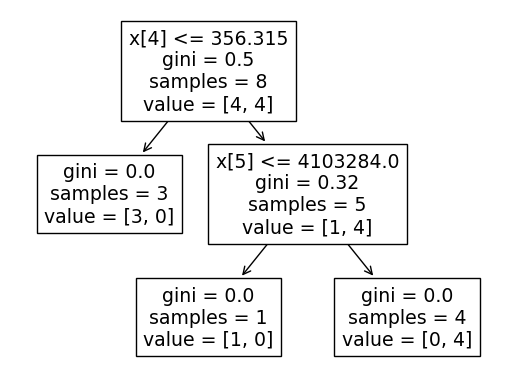

0.2


In [224]:
evaluate(dt_bag1,X,y)

In [225]:
# Data for Tree 2
df_bag = df_train.sample(8,replace=True)

# Fetch X and y
X = df_bag.iloc[:,0:12]
y = df_bag.iloc[:,-1]

# print df_bag
df_bag

Open        High         Low       Close   Adj Close   
Date                                                                     
2011-10-17  429.429443  430.345764  411.672760  412.985321  380.071564  \
2012-07-20  357.758789  361.003052  355.158447  357.932159  333.418854   
2015-08-19  467.567932  475.988098  465.314270  472.818146  454.609558   
2012-10-12  405.555725  409.320068  404.193634  405.605255  377.826965   
2013-11-18  425.021210  434.753967  424.055389  433.268066  408.084595   
2016-10-25  527.499817  527.623657  522.150513  525.444336  510.454712   
2011-10-17  429.429443  430.345764  411.672760  412.985321  380.071564   
2011-10-17  429.429443  430.345764  411.672760  412.985321  380.071564   

              Volume  subjectivity  polarity  compound    neg    neu    pos   
Date                                                                          
2011-10-17  10177179  0.405355      0.100663 -0.7003    0.083  0.872  0.044  \
2012-07-20  5725819   0.356836     -0.014459  0.9565    0.046  0.827  0.127   
2015-08-19  4096871   0.397984      0.106048  0.9217    0.048  0.866  0.086   
2012-10-12  4904139   0.381111     -0.078333 -0.5574    0.091  0.832  0.076   
2013-11-18  5571764   0.304762      0.042857 -0.0258    0.067  0.869  0.064   
2016-10-25  3534611   0.231010      0.061873  0.9081    0.000  0.928  0.072   
2011-10-17  10177179  0.405355      0.100663 -0.7003    0.083  0.872  0.044   
2011-10-17  10177179  0.405355      0.100663 -0.7003    0.083  0.872  0.044   

            Label  
Date               
2011-10-17  0      
2012-07-20  0      
2015-08-19  0      
2012-10-12  1      
2013-11-18  1      
2016-10-25  0      
2011-10-17  0      
2011-10-17  0

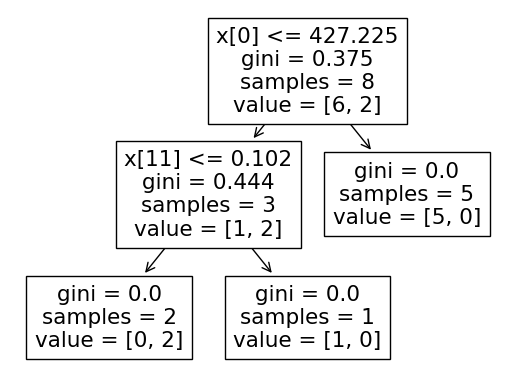

0.6


In [226]:
dt_bag2 = DecisionTreeClassifier()
evaluate(dt_bag2,X,y)

In [227]:
# Data for Tree 3
df_bag = df_train.sample(8,replace=True)

# Fetch X and y
X = df_bag.iloc[:,0:12]
y = df_bag.iloc[:,-1]

# print df_bag
df_bag

Open         High          Low        Close    Adj Close   
Date                                                                          
2015-08-19  467.567932   475.988098   465.314270   472.818146   454.609558   \
2012-12-12  408.626617   413.480621   405.828156   412.390961   384.147919    
2020-08-18  2085.000000  2134.300049  2082.350098  2118.550049  2105.417969   
2013-11-18  425.021210   434.753967   424.055389   433.268066   408.084595    
2012-12-12  408.626617   413.480621   405.828156   412.390961   384.147919    
2011-10-17  429.429443   430.345764   411.672760   412.985321   380.071564    
2012-12-12  408.626617   413.480621   405.828156   412.390961   384.147919    
2012-12-12  408.626617   413.480621   405.828156   412.390961   384.147919    

              Volume  subjectivity  polarity  compound    neg    neu    pos   
Date                                                                          
2015-08-19  4096871   0.397984      0.106048  0.9217    0.048  0.866  0.086  \
2012-12-12  4671957   0.433402     -0.013218 -0.8271    0.079  0.875  0.046   
2020-08-18  14097746  0.387289      0.071351  0.9682    0.033  0.872  0.096   
2013-11-18  5571764   0.304762      0.042857 -0.0258    0.067  0.869  0.064   
2012-12-12  4671957   0.433402     -0.013218 -0.8271    0.079  0.875  0.046   
2011-10-17  10177179  0.405355      0.100663 -0.7003    0.083  0.872  0.044   
2012-12-12  4671957   0.433402     -0.013218 -0.8271    0.079  0.875  0.046   
2012-12-12  4671957   0.433402     -0.013218 -0.8271    0.079  0.875  0.046   

            Label  
Date               
2015-08-19  0      
2012-12-12  1      
2020-08-18  1      
2013-11-18  1      
2012-12-12  1      
2011-10-17  0      
2012-12-12  1      
2012-12-12  1

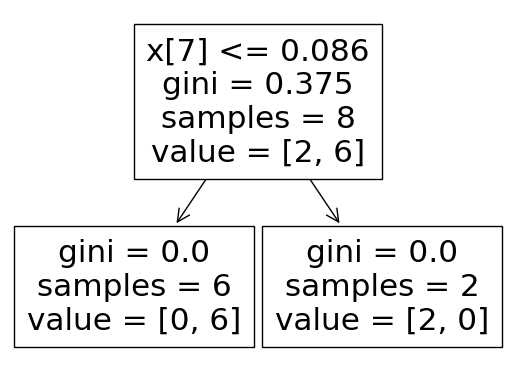

0.2


In [228]:
dt_bag3 = DecisionTreeClassifier()
evaluate(dt_bag3,X,y)

### Predict

In [229]:
df_test

Open        High         Low       Close   Adj Close   
Date                                                                     
2011-08-24  378.413025  381.137207  374.450592  377.075714  347.023865  \
2015-09-15  426.952911  430.915344  423.782959  429.429443  412.891785   
2012-05-08  355.628998  356.074768  346.218201  350.849304  322.887634   
2011-09-28  396.120178  399.364410  390.845184  394.857147  363.388184   
2015-08-25  416.477203  426.284241  407.735077  420.092926  403.914856   

              Volume  subjectivity  polarity  compound    neg    neu    pos   
Date                                                                          
2011-08-24  5993864   0.390456      0.100141  0.0000    0.000  1.000  0.000  \
2015-09-15  5311765   0.338000      0.102000  0.8625    0.000  0.920  0.080   
2012-05-08  7844489   0.397222      0.075741 -0.2732    0.049  0.925  0.026   
2011-09-28  11553462  0.500000      0.300000  0.3182    0.000  0.753  0.247   
2015-08-25  22846211  0.428365      0.068239  0.8937    0.032  0.860  0.108   

            Label  
Date               
2011-08-24  0      
2015-09-15  1      
2012-05-08  0      
2011-09-28  1      
2015-08-25  1

In [234]:
print("Predictor 1",dt_bag1.predict(np.array([396.120178,	399.364410,	390.845184,	394.857147,	363.388184,	11553462,	0.500000,	0.300000,	0.3182,	0.000,	0.753,	0.247	]).reshape(1,12)))
print("Predictor 2",dt_bag2.predict(np.array([396.120178,	399.364410,	390.845184,	394.857147,	363.388184,	11553462,	0.500000,	0.300000,	0.3182,	0.000,	0.753,	0.247	]).reshape(1,12)))
print("Predictor 3",dt_bag3.predict(np.array([396.120178,	399.364410,	390.845184,	394.857147,	363.388184,	11553462,	0.500000,	0.300000,	0.3182,	0.000,	0.753,	0.247	]).reshape(1,12)))



Predictor 1 [1]
Predictor 2 [0]
Predictor 3 [0]


In [235]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [236]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

print("Decision Tree accuracy",accuracy_score(y_test,y_pred))

Decision Tree accuracy 0.8


In [237]:

bag = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=0.25,
    bootstrap=True,
    random_state=42
)

In [238]:
bag.fit(X_train,y_train)
y_pred = bag.predict(X_test)
accuracy_score(y_test,y_pred)

0.8

In [239]:
bag.estimators_samples_[0].shape

(200,)

In [240]:
bag.estimators_features_[0].shape

(12,)

In [241]:

bag = BaggingClassifier(
    base_estimator=SVC(),
    n_estimators=500,
    max_samples=0.25,
    bootstrap=True,
    random_state=42
)

In [242]:
bag.fit(X_train,y_train)
y_pred = bag.predict(X_test)
print("Bagging using SVM",accuracy_score(y_test,y_pred))

Bagging using SVM 0.4


### OOB Score

In [243]:

bag = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=0.25,
    bootstrap=True,
    oob_score=True,
    random_state=42
)

In [244]:

bag.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.25,
                  n_estimators=500, oob_score=True, random_state=42)

In [116]:

bag.oob_score_

0.43570536828963796

In [246]:
y_pred = bag.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))

Accuracy 0.8


### Bagging Tips
Bagging generally gives better results than Pasting
Good results come around the 25% to 50% row sampling mark
Random patches and subspaces should be used while dealing with high dimensional data
To find the correct hyperparameter values we can do GridSearchCV/RandomSearchCV
### Applying GridSearchCV

In [247]:
from sklearn.model_selection import GridSearchCV

In [248]:
parameters = {
    'n_estimators': [50,100,500], 
    'max_samples': [0.1,0.4,0.7,1.0],
    'bootstrap' : [True,False],
    'max_features' : [0.1,0.4,0.7,1.0]
    }

In [250]:

search = GridSearchCV(BaggingClassifier(), parameters, cv=5)

In [251]:
search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=BaggingClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': [0.1, 0.4, 0.7, 1.0],
                         'max_samples': [0.1, 0.4, 0.7, 1.0],
                         'n_estimators': [50, 100, 500]})

In [252]:

search.best_params_
search.best_score_

0.52125

In [253]:
search.best_params_

{'bootstrap': True,
 'max_features': 1.0,
 'max_samples': 0.7,
 'n_estimators': 50}